In [1]:
#====================================================================================================
# kogpt2 를 이용해 훈련한 모델 추론(생성) 요약(abstractive summarization) 훈련 예시
# => 
# => https://www.nbshare.io/notebook/764386829/Amazon-Review-Summarization-Using-GPT-2-And-PyTorch/
#
# => text generation 모델이므로  acc 구하는 것은 의미 없음(*따라서 train loss, val loss 만 구함)
#
# => 여기서는 훈련할때 요약할 문장과 요약 문장사이에 구분자 토큰을 <segment>로 지정하였음.(해당 토큰은 다른것으로 지정하여 훈련시켜도 됨)
@
# [훈련 dataset]
# => input_ids = '요약할 문장<segment>요약문</s>'    : <segment>토큰은 요약할 문장과 요약문 사이 구분자로 대체 가능함
# => labels = input_ids와 동일
#
# [추론(생성) 요약(abstractive summarization) 훈련 과정]
# 
# 1. gpt-2 모델 선언(GPT2LMHeadModel), tokenizer 선언(PreTrainedTokenizerFast)
# 2. '요약할 문장+구분token(<summarize>)+요약문+<eos>토큰' 식으로 된 훈련 dataset 생성
# 3. 모델에 input_ids, lables 을 입력하여 훈련 시킴
#====================================================================================================

import torch
from torch.utils.data import Dataset, random_split, DataLoader, RandomSampler, SequentialSampler 
import numpy as np
import pandas as pd
from transformers import GPT2LMHeadModel, PreTrainedTokenizerFast
from transformers import AdamW, get_linear_schedule_with_warmup

from tqdm.notebook import tqdm
import os
import time
from myutils import GPU_info, seed_everything, mlogging, SaveBERTModel, AccuracyForMLM
from summarizer import TransformerSummarizer
model_path='../model/gpt-2/kogpt-2/'
#model_path='skt/kogpt2-base-v2'
#model_path = "gpt2-medium"

# 출력
OUTPATH = '../model/gpt-2/kogpt-2-ft-summarizer-0504/'

device = GPU_info()
print(device)

#seed 설정
seed_everything(222)

#logging 설정
logger =  mlogging(loggername="gpt2-ft", logfilename="../log/gpt2-ft")

logfilepath:../log/bwdataset_2022-05-09.log
logfilepath:../log/qnadataset_2022-05-09.log
True
device: cuda:0
cuda index: 0
gpu 개수: 1
graphic name: NVIDIA A30
cuda:0
logfilepath:../log/gpt2-ft_2022-05-09.log


In [2]:
# 요약문 corpus 파일 열기 
corpus_path = "../korpora/mycorpus/newspaper.csv"
with open(corpus_path, "r") as reviews_raw:
    reviews = reviews_raw.readlines()

In [3]:
reviews[:3]

['충주시는 민간보조사업의 증가와 보조금 집행관리에 대한 부당 행위가 증가함에따라 15일부터 25일까지 보조금 실태를 파악한 후 8월15일까지 세부감사를 진행  운영실태 전반에 대한 자체 감사를 실시할 계획이라고 밝혔다 ,충주시  민간지원 보조사업 대형축제 운영 감사 돌입\n',
 '국무조정실은 8일 오후 대전시청에서  대전지역 규제혁신 현장간담회 를 열고 대전과 충남에 취약한 뿌리산업 육성방안으로 규제개선을 논의하였으며  관계자는 기업과 국민들이 체감할 수 있는 규제개선이 이루어지도록 최대한 노력할 것이라고 밝혔다 ,대전도 뿌리산업 특화단지 길 열린다   국무조정실 규제개선키로\n',
 '중국 경제일간지 21세기경제보도는 중국 대형 생명보험사인 차이나라이프가  차이나라이프 중흥 이라는 전략적 목표를 세우고 비즈니스 중심의 조직 시스템 구축과 인터넷 생명보험회사 설립에 착수 중이라고 17일 보도하였다 ,중국 생보사 차이나라이프  인터넷 보험사 설립 추진\n']

In [4]:
print(len(reviews))

3091


In [5]:
# reviews 문장은 text, 요약문 식으로 되어 있다.
# => 이 구분자 , 를 <summarize> 로 변경함.(*<summarize> 토큰이 아니라, 다른 토큰을 지정해도 됨)
reviews = [review.replace(",", "<summarize>") for review in reviews]

In [6]:
reviews[1]

'국무조정실은 8일 오후 대전시청에서  대전지역 규제혁신 현장간담회 를 열고 대전과 충남에 취약한 뿌리산업 육성방안으로 규제개선을 논의하였으며  관계자는 기업과 국민들이 체감할 수 있는 규제개선이 이루어지도록 최대한 노력할 것이라고 밝혔다 <summarize>대전도 뿌리산업 특화단지 길 열린다   국무조정실 규제개선키로\n'

In [7]:
# 총 단어의 길이를 얻어옴
avg_length = sum([len(review.split()) for review in reviews])/len(reviews)
avg_length

35.62924619864122

In [8]:
# 총 단어의 길이보다 길게 설정
max_length = 100

In [9]:
# tokenizer 로딩 
tokenizer = PreTrainedTokenizerFast.from_pretrained(model_path,
                                                   bos_token='</s>',
                                                   eos_token='</s>',
                                                   unk_token='<unk>',
                                                   pad_token='<pad>',
                                                   mask_token='<mask>')

In [10]:
# 모델 정의 하고, embedding size를 tokenizer 사이즈만큼 조정
model = GPT2LMHeadModel.from_pretrained(model_path)

model.resize_token_embeddings(len(tokenizer))
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(51200, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )


In [11]:
# ** 구분자  <summarize> 토큰의 길이를 얻어옴
print(tokenizer.encode("<summarize>"))
extra_length = len(tokenizer.encode("<summarize>"))
print(f'***<summarize> token len:{extra_length}')


[9724, 457, 459, 10473, 9837, 21049, 443, 405]
***<summarize> token len:8


In [12]:
# dataset 설정 함수
class summarizeDataset(Dataset):
    def __init__(self, tokenizer, sentences, max_len, summarize_token_len):
        self.max_len = max_len
        self.tokenizer = tokenizer
        self.eos = self.tokenizer.eos_token
        self.eos_id = self.tokenizer.eos_token_id
        self.sentences = sentences
        self.summarize_token_len = summarize_token_len
        self.result = []
        
        for sentence in self.sentences:
            # 한 문장 뒤에 </s>(EOS 토큰) 추가
            tokenized = self.tokenizer.encode(sentence + self.eos)
            #print(tokenized)
            # padd 
            padded = self.pad_truncate(tokenized)
            
            # 출력
            self.result.append(torch.tensor(padded))
           
    def __len__(self):
        return len(self.result)
    
    def __getitem__(self, item):
        return self.result[item]
    
    # padd 붙이는 함수
    def pad_truncate(self, name):
        
        # name_length는 총 name 길이에서 - summzrize_token 길이를 뺀 길이가 됨
        # (예: name 길이 = 110 이면 name_length = 110 - 8 = 102)
        name_length = len(name) - self.summarize_token_len
        
        # name 길이 < 100 작으면, 뒤에 108개까지는 eos_id(1)로 padd 붙임
        if name_length < self.max_len:
            difference = self.max_len - name_length
            result = name + [self.eos_id] * difference
        # name 길이 > 100 크면, 100+7 까지만 name 값 출력하고, 뒤에 eos_id(1) 붙임 = 총 108개가 됨
        elif name_length > self.max_len:
            result = name[:self.max_len + self.summarize_token_len - 1]+[self.eos_id]
        else:
            result = name
        
        return result
        

In [13]:
# dataset 만듬
dataset = summarizeDataset(tokenizer, reviews, max_length, extra_length)

In [14]:
dataset[1]

tensor([14932, 13305, 16428, 16308, 21734, 13899,  7888, 29718,   739, 13899,
         9635, 17143, 25002, 16380,  6826,  7191,  8765, 36055, 20759,  9026,
        12391, 27775,  8022,  9499, 16455, 13961, 10258, 16891,  7607, 21609,
        17143,  6841, 10402, 13564, 15423,   739,  9804,  9599, 50865,  9888,
         9136, 48262,  8705,  9025,  9080, 17143,  6841, 10886,  9442, 25682,
        19226, 10805,  8705, 11839, 28296,  7182,  9724,   457,   459, 10473,
         9837, 21049,   443,   405, 10238,  7235, 13961, 10258,  9125,  8756,
        18081,  9367, 13363,  7182,   739,   739, 14932, 13305,  7892, 17143,
        32931,  8511,  7426,   375,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1])

In [15]:
# 데이터 로더 생성 
batch_size = 32
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [16]:
# 훈련 시작 

##################################################
epochs = 2            # epochs
learning_rate = 3e-5  # 학습률
##################################################

# optimizer 적용
optimizer = AdamW(model.parameters(), 
                 lr=learning_rate, 
                 eps=1e-8) # 0으로 나누는 것을 방지하기 위한 epsilon 값(10^-6 ~ 10^-8 사이 이값 입력합)

# 총 훈련과정에서 반복할 스탭
total_steps = len(train_loader)*epochs
warmup_steps = total_steps * 0.1 #10% of train data for warm-up

# 손실률 보여줄 step 수
p_itr = int(len(train_loader)*0.1)  
    
# step마다 모델 저장
save_steps = int(total_steps * 0.5)
    
# 스캐줄러 생성
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=warmup_steps, 
                                            num_training_steps=total_steps)

itr = 1

total_loss = 0
list_train_loss = []

# 그래디언트 초기화(*set_to_none=True 로 설정하면, 그래디언트 업데이트시, 쓰기작업만 수행되어 속도가 빨라진다)
model.zero_grad(set_to_none=True)
for epoch in tqdm(range(epochs)):

    model.train() # 훈련모드로 변환
    for data in tqdm(train_loader):
        model.zero_grad(set_to_none=True)# 그래디언트 초기화(*set_to_none=True 로 설정하면, 그래디언트 업데이트시, 쓰기작업만 수행되어 속도가 빨라진다)
        
        # 입력 값 설정
        input_ids = data.to(device)
        labels = data.to(device)
        #print('Labels:{}'.format(labels))
        
        # 모델 실행
        outputs = model(input_ids=input_ids, 
                        labels=labels)
        
       
        # 출력값 loss,logits를 outputs에서 얻어옴
        loss = outputs.loss
        logits = outputs.logits
        #print('Loss:{}, logits:{}'.format(loss, logits))
        
        # logits_shape: torch.Size([32, 68, 51200])
        # => batch_size, sequence_max_len, token_len
        #print(f'logits_shape: {logits.shape}')                    
        
        # optimizer 과 scheduler 업데이트 시킴
        loss.backward()   # backward 구함
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)   # 그래디언트 클리핑 (gradient vanishing이나 gradient exploding 방지하기 위한 기법)
        optimizer.step()  # 가중치 파라미터 업데이트(optimizer 이동)
        scheduler.step()  # 학습률 감소
        
        # ***further pretrain 에는 손실률 계산을 넣지 않음
        # 정확도 계산하는 부분은 no_grade 시켜서, 계산량을 줄임.
        
        # => torch.no_grad()는 gradient을 계산하는 autograd engine를 비활성화 하여 
        # 필요한 메모리를 줄이고, 연산속도를 증가시키는 역활을 함
        with torch.no_grad():
            
            # 손실률 계산
            total_loss += loss.item()
                
            #===========================================
            # 정확도(Accurarcy) 계산
            #correct = AccuracyForMLM(logits, labels, attention_mask)           
            #total_correct += correct.sum().item() 
            #total_len += attention_mask.sum().item()
            #=========================================
     
            # 주기마다 test(validataion) 데이터로 평가하여 손실류 계산함.
            if itr % p_itr == 0:
                
                train_loss = total_loss/p_itr
                                   
                logger.info('[Epoch {}/{}] Iteration {} -> Train Loss: {:.4f}'.format(epoch+1, epochs, itr, train_loss))
                     
                list_train_loss.append(train_loss)
                 
                # 변수들 초기화    
                total_loss = 0
                ####################################################################
            if itr % save_steps == 0:
                #전체모델 저장
                SaveBERTModel(model, tokenizer, OUTPATH, epochs, learning_rate, batch_size)

        itr+=1

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

2022-05-09 09:53:04,780 - gpt2-ft - INFO - [Epoch 1/2] Iteration 9 -> Train Loss: 5.2991
2022-05-09 09:53:06,660 - gpt2-ft - INFO - [Epoch 1/2] Iteration 18 -> Train Loss: 2.6479
2022-05-09 09:53:08,595 - gpt2-ft - INFO - [Epoch 1/2] Iteration 27 -> Train Loss: 2.3757
2022-05-09 09:53:10,535 - gpt2-ft - INFO - [Epoch 1/2] Iteration 36 -> Train Loss: 2.3654
2022-05-09 09:53:12,415 - gpt2-ft - INFO - [Epoch 1/2] Iteration 45 -> Train Loss: 2.3134
2022-05-09 09:53:14,278 - gpt2-ft - INFO - [Epoch 1/2] Iteration 54 -> Train Loss: 2.2806
2022-05-09 09:53:16,168 - gpt2-ft - INFO - [Epoch 1/2] Iteration 63 -> Train Loss: 2.2724
2022-05-09 09:53:17,928 - gpt2-ft - INFO - [Epoch 1/2] Iteration 72 -> Train Loss: 2.1756
2022-05-09 09:53:19,756 - gpt2-ft - INFO - [Epoch 1/2] Iteration 81 -> Train Loss: 2.2154
2022-05-09 09:53:21,673 - gpt2-ft - INFO - [Epoch 1/2] Iteration 90 -> Train Loss: 2.2204
2022-05-09 09:53:23,933 - bwpdataset - INFO - ==> save_model : ../model/gpt-2/kogpt-2-ft-summarizer-0

  0%|          | 0/96 [00:00<?, ?it/s]

2022-05-09 09:53:24,583 - gpt2-ft - INFO - [Epoch 2/2] Iteration 99 -> Train Loss: 2.2046
2022-05-09 09:53:26,502 - gpt2-ft - INFO - [Epoch 2/2] Iteration 108 -> Train Loss: 1.9773
2022-05-09 09:53:28,383 - gpt2-ft - INFO - [Epoch 2/2] Iteration 117 -> Train Loss: 2.0098
2022-05-09 09:53:30,326 - gpt2-ft - INFO - [Epoch 2/2] Iteration 126 -> Train Loss: 2.0831
2022-05-09 09:53:32,202 - gpt2-ft - INFO - [Epoch 2/2] Iteration 135 -> Train Loss: 2.0460
2022-05-09 09:53:34,079 - gpt2-ft - INFO - [Epoch 2/2] Iteration 144 -> Train Loss: 1.9574
2022-05-09 09:53:35,976 - gpt2-ft - INFO - [Epoch 2/2] Iteration 153 -> Train Loss: 2.0478
2022-05-09 09:53:37,856 - gpt2-ft - INFO - [Epoch 2/2] Iteration 162 -> Train Loss: 1.9989
2022-05-09 09:53:39,836 - gpt2-ft - INFO - [Epoch 2/2] Iteration 171 -> Train Loss: 2.0246
2022-05-09 09:53:41,709 - gpt2-ft - INFO - [Epoch 2/2] Iteration 180 -> Train Loss: 1.9880
2022-05-09 09:53:43,598 - gpt2-ft - INFO - [Epoch 2/2] Iteration 189 -> Train Loss: 2.0102


In [20]:
# 모델 저장
SaveBERTModel(model, tokenizer, OUTPATH, epochs, learning_rate, batch_size)

2022-05-09 09:59:51,958 - bwpdataset - INFO - ==> save_model : ../model/gpt-2/kogpt-2-ft-summarizer-0504/batch:32-ep:2-lr:0.000030000-5m9d-9:59


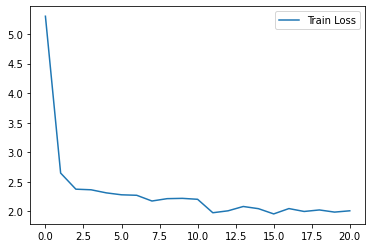

In [17]:
# 그래프로 loss 표기
#!pip install matplotlib
import matplotlib.pyplot as plt

plt.plot(list_train_loss, label='Train Loss')
#plt.plot(list_validation_acc, label='Eval Accuracy')
plt.legend()
plt.show()


In [55]:
# 추론시 topk 알고리즘 사용
def topk(probs, n=9):
    probs = torch.softmax(probs, dim=-1)
    
    tokensProb, topIx = torch.topk(probs, k=n)
    tokensProb = tokensProb / torch.sum(tokensProb)
    
    tokensProb = tokensProb.cpu().detach().numpy()
    
    choice = np.random.choice(n,1,p=tokensProb)
    tokenId = topIx[choice][0]
    
    return int(tokenId)

In [56]:
# summarize 추론 처리 함수 
def model_infer(model, tokenizer, review, max_length=15):
    review_encoded = tokenizer.encode(review)
    result = review_encoded
    initial_input = torch.tensor(review_encoded).unsqueeze(0).to(device)
    
    with torch.set_grad_enabled(False):
        outputs = model(initial_input)
        
        logits = outputs.logits[0,-1]
        print(logits.shape)  # embedding 계수 출력됨
        #result.append(topk(logits))
        #print(result)
        
        for _ in range(max_length):
            input = torch.tensor(result).unsqueeze(0).to(device)
            outputs = model(input)
            logits = outputs.logits[0,-1]
            res_id = topk(logits)
            
            if res_id == tokenizer.eos_token_id:
                return tokenizer.decode(result)
            else:
                result.append(res_id)
                
    return tokenizer.decode(result)
            

In [59]:
# A review is initially fed to the model.
# A choice from the top-k choices is selected.
# The choice is added to the summary and the current sequence is fed to the model.
# Repeat steps 2 and 3 until either max_len is achieved or the EOS token is generated.

body = '''
전남도는 청정하고 안전한 신재생에너지 보급 확산을 위해 추진하는 ‘2022년 신재생에너지 보급 주택지원사업’ 참여 가구를 9일부터 6월 3일까지 모집한다고 밝혔다.
신재생에너지 보급 주택지원사업은 주택에 태양광, 태양열, 연료전지, 지열 등 신재생에너지 설비를 설치하는 도민에게 정부 지원금 외에 도비와 시군비를 추가로 지원하는 사업이다.
사업 대상자로 선정되면 설치비 자부담분(50%)의 40%를 도비와 시군비로 지원하기 때문에 비용부담을 줄일 수 있다.
전남도는 올해 지방비 17억원을 들여 1600여 가구에 신재생에너지 설비를 보급할 계획이다.
지원을 바라는 주택 소유자는 한국에너지공단 그린홈 누리집에서 회원가입 후 공단에 등록한 참여업체를 지정해 신청하면 된다.
지방비 보조금은 한국에너지공단의 최종 사업 승인 후 해당 시군에 지원 신청을 하면 예산 범위에서 선착순 지원한다.
자세한 사항은 한국에너지공단 광주전남지역본부, 전남도 에너지신산업과, 시군 에너지업무 담당 부서로 문의하면 된다.
주택에 3KW 태양광 설비를 설치하면 총 설치비 516만원 중 국비 258만원과 추가로 지방비 103만원을 지원하기 때문에 155만원만 자부담하면 된다.
3KW 태양광 설비를 설치한 가구는 월 4만5000원씩 연간 54만원의 전기요금을 절감할 수 있다.
'''

output = model_infer(model, tokenizer, body + "<summarize>", 100)
#print(output)

summary = output.split("<summarize>")[1].strip()
print(summary)

torch.Size([51200])
여름철 태양열 싼 지역에 태양광 보급
